<h1>This purpose of this notebook is to generate Recipe Names using an Transformer. </h1>

<h2>Importing Necessary Libraries</h2>

In [55]:
# Import standard libraries
import time             # Provides time-related functions
import string           # Contains string constants and utilities
import unicodedata      # Unicode character database
import random # Provides functions for generating random numbers
import math   # Provides mathematical functions

# Import scientific computing libraries
import numpy as np      # Provides support for arrays and mathematical functions
import pandas as pd     # Provides data structures and data analysis tools

# Import PyTorch libraries
import torch                            # PyTorch library for tensor computation and deep learning
import torch.nn as nn                   # Neural network module of PyTorch
import torch.nn.functional as F         # Functional interface of PyTorch neural network module
from torch.nn import Transformer       # Transformer model
from torch.nn.utils.rnn import pad_sequence     # Function for padding sequences
from torch.utils.data import DataLoader, TensorDataset, random_split  # Utilities for data loading and manipulation

# Import machine learning libraries
from sklearn.model_selection import train_test_split  # Function for splitting data into training and test sets
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction   # Functions for computing BLEU score

# Import visualization libraries
import matplotlib.pyplot as plt  # Provides a MATLAB-like plotting framework

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Check if GPU is available

<h2>Import Food Ingredients Dataset</h2>

In [56]:
# Specify the relative file path to the CSV dataset
file_path = '../../Intro-to-DL/datasets/recipes/Food Ingredients and Recipe Dataset with Image Name Mapping.csv'

# Use pandas' read_csv function to load the CSV file into a DataFrame
df = pd.read_csv(file_path)

# Display the first 5 rows of the DataFrame using the head() function
df.head()

,Unnamed: 0,Title,Ingredients,Instructions,Image_Name,Cleaned_Ingredients
0,0,Miso-Butter Roast Chicken With Acorn Squash Pa...,"['1 (3½–4-lb.) whole chicken', '2¾ tsp. kosher...","Pat chicken dry with paper towels, season all ...",miso-butter-roast-chicken-acorn-squash-panzanella,"['1 (3½–4-lb.) whole chicken', '2¾ tsp. kosher..."
1,1,Crispy Salt and Pepper Potatoes,"['2 large egg whites', '1 pound new potatoes (...",Preheat oven to 400°F and line a rimmed baking...,crispy-salt-and-pepper-potatoes-dan-kluger,"['2 large egg whites', '1 pound new potatoes (..."
2,2,Thanksgiving Mac and Cheese,"['1 cup evaporated milk', '1 cup whole milk', ...",Place a rack in middle of oven; preheat to 400...,thanksgiving-mac-and-cheese-erick-williams,"['1 cup evaporated milk', '1 cup whole milk', ..."
3,3,Italian Sausage and Bread Stuffing,"['1 (¾- to 1-pound) round Italian loaf, cut in...",Preheat oven to 350°F with rack in middle. Gen...,italian-sausage-and-bread-stuffing-240559,"['1 (¾- to 1-pound) round Italian loaf, cut in..."
4,4,Newton's Law,"['1 teaspoon dark brown sugar', '1 teaspoon ho...",Stir together brown sugar and hot water in a c...,newtons-law-apple-bourbon-cocktail,"['1 teaspoon dark brown sugar', '1 teaspoon ho..."


<h2>Dataset Preprocessing</h2>

<h3>Feature Extraction</h3>

In [57]:
# Extract the 'Title' column from the DataFrame 'df' and assign it to the variable 'titles'
titles = df['Title']

# Print the first 5 rows of 'titles'
print(titles.head(), '\n')

0    Miso-Butter Roast Chicken With Acorn Squash Pa...
1                      Crispy Salt and Pepper Potatoes
2                          Thanksgiving Mac and Cheese
3                   Italian Sausage and Bread Stuffing
4                                         Newton's Law
Name: Title, dtype: object 



<h3> Remove unusable data and Create vocab of unique characters</h3>

In [58]:
# Remove any rows in 'titles' that contain missing values
titles = titles.dropna()

# Remove any duplicate rows in 'titles'
titles = titles.drop_duplicates()

# Initialize an empty set to store the unique characters in the titles
chars = set()

# Enumerate all the characters in the dataset
for title in titles:
    for char in title:
        # Add each character to the 'chars' set. Since sets only contain unique elements, any duplicate characters will be ignored.
        chars.add(char)

# Sort the characters in alphabetical order
chars = sorted(chars)

# Print the number of unique characters in the dataset
print('Unique characters in the dataset:', len(chars))

# Print the sorted list of unique characters
print(chars, '\n')

# Define a function to filter out unexpected characters from the titles
def filter_unexpected_chars(data):
    # Define the set of expected characters as all ASCII letters, digits, spaces, and some punctuation marks
    expected_chars = set(string.ascii_letters + string.digits + ' ' + '!"#%&\'(),-.:?')
    
    # Initialize an empty list to store the filtered titles
    filtered_data = []
    
    for title in data:
        # For each title, remove any characters that are not in the set of expected characters and are not control or separator characters
        filtered_title = ''.join(char for char in title if unicodedata.category(char)[0] not in ['C', 'Z'] or char in expected_chars)
        
        # Add the filtered title to the list of filtered titles
        filtered_data.append(filtered_title)
    
    # Return the list of filtered titles
    return filtered_data

# Apply the filter function to the titles
filtered_titles = filter_unexpected_chars(titles)

# Print the first 5 filtered titles
for title in filtered_titles[:5]:
    print(title)

Unique characters in the dataset: 136
['\n', ' ', '!', '"', '#', '%', '&', "'", '(', ')', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '9', ':', ';', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '\x92', '\x96', '\xa0', '®', 'Á', 'É', 'à', 'á', 'â', 'ã', 'ä', 'ç', 'è', 'é', 'ê', 'ë', 'ì', 'í', 'î', 'ï', 'ñ', 'ò', 'ó', 'ô', 'ö', 'ø', 'ù', 'ú', 'û', 'ü', 'ō', 'ơ', '̀', '́', '̃', '̉', 'С', 'и', 'к', 'н', 'р', 'ы', '\u2009', '–', '—', '‘', '’', '“', '”', '강', '개', '닭', '된', '장', '전', '정', '찌', '파'] 

Miso-Butter Roast Chicken With Acorn Squash Panzanella
Crispy Salt and Pepper Potatoes
Thanksgiving Mac and Cheese
Italian Sausage and Bread Stuffing
Newton's Law


<h3>Tokenize Input Features</h3>

In [59]:
# Convert each title in 'filtered_titles' into a list of individual characters
titles_split = [list(title) for title in filtered_titles]

# Print the first 5 titles in 'titles_split'. Each title is a list of characters.
for title in titles_split[:5]:
    print(title)

['M', 'i', 's', 'o', '-', 'B', 'u', 't', 't', 'e', 'r', ' ', 'R', 'o', 'a', 's', 't', ' ', 'C', 'h', 'i', 'c', 'k', 'e', 'n', ' ', 'W', 'i', 't', 'h', ' ', 'A', 'c', 'o', 'r', 'n', ' ', 'S', 'q', 'u', 'a', 's', 'h', ' ', 'P', 'a', 'n', 'z', 'a', 'n', 'e', 'l', 'l', 'a']
['C', 'r', 'i', 's', 'p', 'y', ' ', 'S', 'a', 'l', 't', ' ', 'a', 'n', 'd', ' ', 'P', 'e', 'p', 'p', 'e', 'r', ' ', 'P', 'o', 't', 'a', 't', 'o', 'e', 's']
['T', 'h', 'a', 'n', 'k', 's', 'g', 'i', 'v', 'i', 'n', 'g', ' ', 'M', 'a', 'c', ' ', 'a', 'n', 'd', ' ', 'C', 'h', 'e', 'e', 's', 'e']
['I', 't', 'a', 'l', 'i', 'a', 'n', ' ', 'S', 'a', 'u', 's', 'a', 'g', 'e', ' ', 'a', 'n', 'd', ' ', 'B', 'r', 'e', 'a', 'd', ' ', 'S', 't', 'u', 'f', 'f', 'i', 'n', 'g']
['N', 'e', 'w', 't', 'o', 'n', "'", 's', ' ', 'L', 'a', 'w']


In [60]:
# Define a class for special tokens. These tokens have special meanings in the context of sequence-to-sequence models.
class SpecialTokens:
    PAD = '<PAD>'  # Padding token. Used to fill in sequences to make them all the same length.
    SOS = '<SOS>'  # Start-of-sequence token. Indicates the start of a sequence.
    EOS = '<EOS>'  # End-of-sequence token. Indicates the end of a sequence.
    UNK = '<UNK>'  # Unknown token. Used to represent characters not in the vocabulary.
    Tokens = [PAD, SOS, EOS, UNK]  # List of all special tokens.

# Extend the vocabulary with the special tokens.
vocab = SpecialTokens.Tokens + list(chars)

# Print the vocabulary, which now includes the special tokens.
print("Vocabulary:")
print(vocab, '\n')

# Add the start-of-sequence and end-of-sequence tokens to each title. 
# Each title is now a list that starts with the SOS token, ends with the EOS token, and has the original characters in between.
titles_split_with_special_tokens = [[SpecialTokens.SOS] + title + [SpecialTokens.EOS] for title in titles_split]


print("Titles split with special tokens: ")
# Print the first 5 titles, which now include the special tokens.
for title in titles_split_with_special_tokens[:5]:
    print(title)

Vocabulary:
['<PAD>', '<SOS>', '<EOS>', '<UNK>', '\n', ' ', '!', '"', '#', '%', '&', "'", '(', ')', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '9', ':', ';', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '\x92', '\x96', '\xa0', '®', 'Á', 'É', 'à', 'á', 'â', 'ã', 'ä', 'ç', 'è', 'é', 'ê', 'ë', 'ì', 'í', 'î', 'ï', 'ñ', 'ò', 'ó', 'ô', 'ö', 'ø', 'ù', 'ú', 'û', 'ü', 'ō', 'ơ', '̀', '́', '̃', '̉', 'С', 'и', 'к', 'н', 'р', 'ы', '\u2009', '–', '—', '‘', '’', '“', '”', '강', '개', '닭', '된', '장', '전', '정', '찌', '파'] 

Titles split with special tokens: 
['<SOS>', 'M', 'i', 's', 'o', '-', 'B', 'u', 't', 't', 'e', 'r', ' ', 'R', 'o', 'a', 's', 't', ' ', 'C', 'h', 'i', 'c', 'k', 'e', 'n', ' ', 'W', 'i', 't', 'h', ' ', 'A', 'c', 'o', 'r', 'n', ' ', 'S', 'q', 'u', 'a', 's',

<h3> Create a dictionary to map characters to integers and vice versa</h3>

In [61]:
# Create a dictionary that maps each character in the vocabulary to a unique integer index
char_to_idx = {char: idx for idx, char in enumerate(vocab)}

# Create a dictionary that maps each unique integer index to the corresponding character in the vocabulary
idx_to_char = {idx: char for char, idx in char_to_idx.items()}

# Convert each title into a sequence of integer indices. If a character is not in the vocabulary, use the index of the special UNK (unknown) token
titles_ints = [[char_to_idx.get(char, char_to_idx[SpecialTokens.UNK]) for char in title] for title in titles_split_with_special_tokens]

# Pad each sequence of integer indices to the same length, using the index of the special PAD (padding) token for padding. Convert each sequence to a PyTorch tensor of type long
titles_ints_padded = pad_sequence([torch.tensor(title, dtype=torch.long) for title in titles_ints], batch_first=True, padding_value=char_to_idx[SpecialTokens.PAD])

# Convert the list of padded sequences into a 2D PyTorch tensor (optional)
titles_ints_tensor = torch.tensor(titles_ints_padded, dtype=torch.long)

# Print the shape of the titles_ints tensor. This should be (n, m), where n is the number of titles and m is the length of the longest title
print(titles_ints_tensor.shape)

# Print the first 5 sequences of integer indices
for title in titles_ints_tensor[:5]:
    print(title)

torch.Size([13305, 114])
tensor([ 1, 42, 64, 74, 70, 16, 31, 76, 75, 75, 60, 73,  5, 47, 70, 56, 74, 75,
         5, 32, 63, 64, 58, 66, 60, 69,  5, 52, 64, 75, 63,  5, 30, 58, 70, 73,
        69,  5, 48, 72, 76, 56, 74, 63,  5, 45, 56, 69, 81, 56, 69, 60, 67, 67,
        56,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0])
tensor([ 1, 32, 73, 64, 74, 71, 80,  5, 48, 56, 67, 75,  5, 56, 69, 59,  5, 45,
        60, 71, 71, 60, 73,  5, 45, 70, 75, 56, 75, 70, 60, 74,  2,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0

C:\Users\aidan_000\AppData\Local\Temp\ipykernel_18592\1093977298.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  titles_ints_tensor = torch.tensor(titles_ints_padded, dtype=torch.long)


<h3>Convert text to indices</h3>

In [62]:
# Define a function to convert sequences of integer indices back to text
def text_from_ids(ids, idx_to_char):
    # For each sequence of indices, map each index to its corresponding character using the 'idx_to_char' dictionary
    # Join the characters together to form a string, and add this string to a list
    # Return the list of strings
    return [''.join(idx_to_char[idx.item()] for idx in seq) for seq in ids]

# Use the 'text_from_ids' function to convert the 'titles_ints_tensor' tensor back to text
# The 'idx_to_char' dictionary is used to map each index to its corresponding character
titles_text = text_from_ids(titles_ints_tensor, idx_to_char)

# Print the first 5 titles after conversion
for title in titles_text[:5]:
    print(title, '\n')

<SOS>Miso-Butter Roast Chicken With Acorn Squash Panzanella<EOS><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD> 

<SOS>Crispy Salt and Pepper Potatoes<EOS><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD> 

<SOS>Thanksgiving Mac and Cheese<EOS><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><P

<h3>Create Train, Validation, and Test Dataset</h3>

In [63]:
# Convert the 'titles_ints_tensor' tensor to a NumPy array and assign it to 'titles_ints_array'
titles_ints_array = titles_ints_tensor.numpy()

# Calculate the sizes of the train, validation, and test sets
# The train set will contain 60% of the data, the validation set will contain 20%, and the test set will contain the remaining 20%
train_size = int(0.6 * len(titles_ints_array))
val_size = int(0.2 * len(titles_ints_array))
test_size = len(titles_ints_array) - train_size - val_size

# Use the 'random_split' function to split 'titles_ints_array' into a train set and a combined validation/test set
train_ids, val_test_ids = random_split(titles_ints_array, [train_size, val_size + test_size])

# Further split the combined validation/test set into separate validation and test sets
val_ids, test_ids = random_split(val_test_ids, [val_size, test_size])

In [64]:
# Convert the 'train_ids', 'val_ids', and 'test_ids' lists to NumPy arrays of 64-bit integers
train_ids_array = np.array(train_ids, dtype=np.int64)
val_ids_array = np.array(val_ids, dtype=np.int64)
test_ids_array = np.array(test_ids, dtype=np.int64)

# Create PyTorch TensorDataset objects from the NumPy arrays
# TensorDataset is a utility that wraps tensors into a dataset
train_ids_ds = TensorDataset(torch.from_numpy(train_ids_array))
val_ids_ds = TensorDataset(torch.from_numpy(val_ids_array))
test_ids_ds = TensorDataset(torch.from_numpy(test_ids_array))

# Print the number of examples in the training, validation, and test sets
print('Number of training examples:', len(train_ids_ds))
print('Number of validation examples:', len(val_ids_ds))
print('Number of test examples:', len(test_ids_ds))

# Loop over the first 5 elements in the 'train_ids_array' array
for ids in train_ids_array[:5]:
    # Convert the scalar integer to a list containing a single integer
    ids_list = [ids]
    # Use the 'text_from_ids' function to convert the list of integer indices back to text
    # The 'idx_to_char' dictionary is used to map each index to its corresponding character
    print('\n', text_from_ids(ids_list, idx_to_char))

Number of training examples: 7983
Number of validation examples: 2661
Number of test examples: 2661

 ['<SOS>Braised Duck Legs and Sautéed Duck Breast<EOS><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>']

 ['<SOS>Fried Egg on Toast with Salted Herb Butter and Radishes<EOS><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>']

 ['<SOS>Steak Tacos with Cilantro-Radish Salsa<EOS><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PA

In [65]:
# Define a function to split a sequence into input and target sequences
def split_input_target(sequence):
    # The input sequence consists of all but the last character in the sequence
    input_text = sequence[:-1]
    # The target sequence consists of all but the first character in the sequence
    target_text = sequence[1:]
    # Return the input and target sequences
    return input_text, target_text

# Use a list comprehension to apply the 'split_input_target' function to each sequence in the training, validation, and test sets
# This creates a pair of input-target sequences for each sequence
train_ds = [(split_input_target(ids)) for ids, in train_ids_ds]
val_ds = [(split_input_target(ids)) for ids, in val_ids_ds]
test_ds = [(split_input_target(ids)) for ids, in test_ids_ds]

In [66]:
# Define the batch size, which is the number of examples to process in a single pass
BATCH_SIZE = 32

# Define the buffer size, which is the number of examples from which to randomly sample
BUFFER_SIZE = 10000

# Create a DataLoader for the training dataset
# The DataLoader batches the data, shuffles it, and drops the last batch if it's not full
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

# Create a DataLoader for the validation dataset
# The DataLoader batches the data, shuffles it, and drops the last batch if it's not full
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

# Create a DataLoader for the test dataset
# The DataLoader batches the data, shuffles it, and drops the last batch if it's not full
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

# Print the number of batches in the training, validation, and test loaders
print('Number of training batches:', len(train_loader))
print('Number of validation batches:', len(val_loader))
print('Number of test batches:', len(test_loader))

# Print the shape of the first batch of input sequences in the training loader
# The shape should be (batch_size, sequence_length)
for input_seq, target_seq in train_loader:
    print('\nInput sequence shape:', input_seq.shape)
    break

Number of training batches: 249
Number of validation batches: 83
Number of test batches: 83

Input sequence shape: torch.Size([32, 113])


<h2> RecipeTitleTransformer Architecture</h2>

In [67]:
# Define a class for positional encoding
class PositionalEncoding(nn.Module):
    # Initialize the positional encoding
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        # Call the parent class's constructor
        super(PositionalEncoding, self).__init__()
        # Initialize a dropout layer with the specified dropout rate
        self.dropout = nn.Dropout(p=dropout)

        # Create a zero matrix with dimensions (max_len, d_model)
        pe = torch.zeros(max_len, d_model)

        # Create a tensor representing the position in the sequence
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)

        # Calculate the division term for the positional encoding formula
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        # Apply the sine function to even indices in the array
        pe[:, 0::2] = torch.sin(position * div_term)

        # Apply the cosine function to odd indices in the array
        pe[:, 1::2] = torch.cos(position * div_term)

        # Add an extra dimension to the positional encoding matrix and transpose the first two dimensions
        pe = pe.unsqueeze(0).transpose(0, 1)

        # Register the positional encoding matrix as a buffer that should not be considered a model parameter
        self.register_buffer('pe', pe)

    # Define the forward pass of the positional encoding
    def forward(self, x):
        # Add the positional encoding to the input tensor and apply dropout
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [68]:
# Define a transformer model for generating recipe titles
class RecipeTitleTransformer(nn.Module):
    # Initialize the transformer model
    def __init__(self, vocab_size, d_model, nhead, num_layers):
        # Call the parent class's constructor
        super(RecipeTitleTransformer, self).__init__()
        # Set the model type
        self.model_type = 'Transformer'
        # Initialize the source mask as None
        self.src_mask = None
        # Initialize the positional encoder with the model dimension
        self.pos_encoder = PositionalEncoding(d_model)
        # Initialize the transformer layer with the specified number of heads and layers
        self.transformer = Transformer(d_model, nhead, num_layers)
        # Initialize the encoder as an embedding layer with the specified vocabulary size and model dimension
        self.encoder = nn.Embedding(vocab_size, d_model)
        # Set the model dimension
        self.d_model = d_model
        # Initialize the decoder as a linear layer with the specified model dimension and vocabulary size
        self.decoder = nn.Linear(d_model, vocab_size)

    # Define the forward pass of the model
    def forward(self, src):
        # If the source mask is None or its size doesn't match the length of the source, generate a new mask
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            mask = self._generate_square_subsequent_mask(len(src)).to(src.device)
            self.src_mask = mask

        # Pass the source through the encoder and scale it by the square root of the model dimension
        src = self.encoder(src) * math.sqrt(self.d_model)
        # Pass the encoded source through the positional encoder
        src = self.pos_encoder(src)
        # Pass the encoded and positionally encoded source through the transformer
        output = self.transformer(src, src, self.src_mask)
        # Pass the transformer output through the decoder
        output = self.decoder(output)
        # Return the decoded output
        return output

    # Generate a square subsequent mask of the specified size
    def _generate_square_subsequent_mask(self, sz):
        # Create a square matrix of ones and take the upper triangular part
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        # Replace the zeros in the mask with negative infinity and the ones with zero
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        # Return the mask
        return mask

In [69]:
# Define a simple transformer model
class SimpleTransformer(nn.Module):
    # Initialize the transformer model
    def __init__(self, vocab_size, d_model, nhead, num_layers):
        # Call the parent class's constructor
        super(SimpleTransformer, self).__init__()
        # Initialize the transformer layer with the specified number of heads and layers
        self.transformer = Transformer(d_model, nhead, num_layers)
        # Initialize the encoder as an embedding layer with the specified vocabulary size and model dimension
        self.encoder = nn.Embedding(vocab_size, d_model)
        # Initialize the decoder as a linear layer with the specified model dimension and vocabulary size
        self.decoder = nn.Linear(d_model, vocab_size)

    # Define the forward pass of the model
    def forward(self, src):
        # Pass the input through the encoder
        src = self.encoder(src)
        # Pass the encoded input through the transformer
        output = self.transformer(src, src)
        # Pass the transformer output through the decoder
        output = self.decoder(output)
        # Return the decoded output
        return output

<h2> Hyperparameters </h2>

In [72]:
# Define the size of the vocabulary, which is the number of unique characters in the text
# This is used in the StringLookup layer, which converts strings to integer indices
vocab_size = len(vocab)

# Define the dimensionality of the embedding space
# This is the size of the vector space in which words will be embedded
# It defines the size of the output vectors from this layer for each word
embedding_dim = 256

# Define the number of features in the input of the transformer model
# This is the dimensionality of the input space of the transformer model
d_model = 512

# Initialize a transformer model with the defined parameters
# The model is moved to the device (GPU or CPU) where it will run
model = RecipeTitleTransformer(vocab_size=len(vocab), d_model=d_model, nhead=4, num_layers=2).to(device)

# Loop over the batches of data in the training data loader
for input_example_batch, target_example_batch in train_loader:
    # Move the input and target data to the same device as the model
    input_example_batch, target_example_batch = input_example_batch.to(device), target_example_batch.to(device)
    
    # Pass the input data through the model to get predictions
    example_batch_predictions = model(input_example_batch)
    
    # Print the shape of the predictions
    # The shape should be (batch_size, sequence_length, vocab_size)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")
    
    # Break the loop after the first batch
    break

torch.Size([32, 113, 140]) # (batch_size, sequence_length, vocab_size)


In [73]:
# Define the loss function for the model
# The loss function is the negative log-likelihood loss with logits
# It is suitable for training a classification problem with multiple classes
loss_fn = nn.CrossEntropyLoss(ignore_index=char_to_idx[SpecialTokens.PAD])

# Define the optimizer for the model
# The Adam optimizer is a popular optimizer that adapts the learning rate during training
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Define the number of epochs, which is the number of times the model will iterate over the entire training dataset
EPOCHS = 20

<h2>Training Loop</h2>

In [74]:
# Initialize lists to store the training and validation losses
train_losses = []
val_losses = []

# Start the training loop
for epoch in range(EPOCHS):
    # Set the model to training mode
    model.train()
    
    # Initialize a variable to accumulate the training loss
    running_loss = 0.0
    
    # Iterate over the batches in the training data loader
    for input_batch, target_batch in train_loader:
        # Move the input and target batches to the GPU
        input_batch, target_batch = input_batch.to(device), target_batch.to(device)

        # Zero the gradients
        optimizer.zero_grad()
        
        # Perform a forward pass through the model
        predictions = model(input_batch)
        
        # Compute the loss
        loss = loss_fn(predictions.transpose(1, 2), target_batch)
        
        # Perform a backward pass to compute gradients
        loss.backward()
        
        # Update the model parameters
        optimizer.step()
        
        # Accumulate the training loss
        running_loss += loss.item()
        
    # Compute the average training loss for the epoch
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    
    # Switch the model to evaluation mode for validation
    model.eval()
    
    # Initialize a variable to accumulate the validation loss
    running_loss = 0.0
    
    # Iterate over the batches in the validation data loader
    for input_batch, target_batch in val_loader:
        # Move the input and target batches to the GPU
        input_batch, target_batch = input_batch.to(device), target_batch.to(device)
        
        # Perform a forward pass through the model
        predictions = model(input_batch)
        
        # Compute the loss
        loss = loss_fn(predictions.transpose(1, 2), target_batch)
        
        # Accumulate the validation loss
        running_loss += loss.item()

    # Compute the average validation loss for the epoch
    val_loss = running_loss / len(val_loader)
    val_losses.append(val_loss)

    # Print the training and validation losses for this epoch
    print(f"Epoch {epoch+1}/{EPOCHS}, Training Loss: {format(train_loss, '.3f')}, Validation Loss: {format(val_loss, '.3f')}")

Epoch 1/20, Training Loss: 3.436, Validation Loss: 3.348
Epoch 2/20, Training Loss: 3.347, Validation Loss: 3.345
Epoch 3/20, Training Loss: 3.346, Validation Loss: 3.341
Epoch 4/20, Training Loss: 3.344, Validation Loss: 3.341
Epoch 5/20, Training Loss: 3.344, Validation Loss: 3.341
Epoch 6/20, Training Loss: 3.343, Validation Loss: 3.341
Epoch 7/20, Training Loss: 3.343, Validation Loss: 3.342
Epoch 8/20, Training Loss: 3.332, Validation Loss: 3.341
Epoch 9/20, Training Loss: 3.317, Validation Loss: 3.330
Epoch 10/20, Training Loss: 3.342, Validation Loss: 3.340
Epoch 11/20, Training Loss: 3.342, Validation Loss: 3.340
Epoch 12/20, Training Loss: 3.334, Validation Loss: 3.300
Epoch 13/20, Training Loss: 3.341, Validation Loss: 3.340
Epoch 14/20, Training Loss: 3.340, Validation Loss: 3.340
Epoch 15/20, Training Loss: 3.336, Validation Loss: 3.326
Epoch 16/20, Training Loss: 3.288, Validation Loss: 3.328
Epoch 17/20, Training Loss: 3.285, Validation Loss: 3.282
Epoch 18/20, Training L

In [75]:
# Save the model checkpoint
# torch.save(model.state_dict(), 'RecipeTransformer.pth')

<h2>Training and Validation Loss Plots</h2>

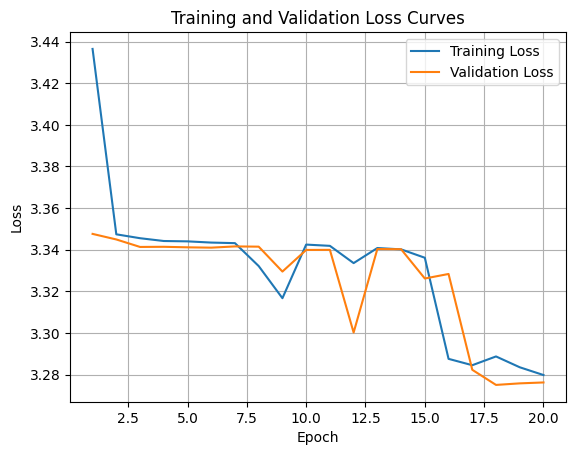

In [76]:
# Plotting the training and validation loss curves
plt.plot(range(1, EPOCHS+1), train_losses, label='Training Loss')
plt.plot(range(1, EPOCHS+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.grid(True)
plt.show()

<h2>Recipe Generator</h2>

In [77]:
# Define a class for generating recipe titles
class RecipeTitleGenerator:
    # The constructor takes a model, mappings from indices to characters and vice versa, and a temperature
    def __init__(self, model, idx_to_char, char_to_idx, temperature=1.0):
        # Store the parameters
        self.temperature = temperature
        self.model = model.to(device)  # Move the model to the device
        self.idx_to_char = idx_to_char
        self.char_to_idx = char_to_idx
        self.start_token_idx = char_to_idx['<SOS>']  # Start of sequence token
        self.end_token_idx = char_to_idx['<EOS>']  # End of sequence token
        self.device = device  # Device to use for computation (CPU or GPU)
        # Move end_token_idx to the device
        self.end_token_idx = torch.tensor(self.end_token_idx, dtype=torch.long).to(device)

    # Define a method to generate one step of the sequence
    def generate_one_step(self, input_ids=None):
        # Ensure that gradients are not computed
        with torch.no_grad():
            # Move the input IDs to the device
            input_ids = input_ids.to(self.device)
            # Perform a forward pass through the model
            logits = self.model(input_ids)
            # Scale the logits by the temperature and apply a softmax to get probabilities
            logits = logits[:, -1, :] / self.temperature
            logits = F.log_softmax(logits, dim=-1)
            # Sample from the probabilities to get the predicted ID
            predicted_id = torch.multinomial(logits.exp(), num_samples=1)
        # Return the predicted ID and the state
        return predicted_id

    # Define a method to generate a sequence
    def generate(self, prompt=None, max_tokens=200, prepend_start_token=True, repeats=1):
        # Initialize the next ID and the state
        next_id = None
        state = None

        # If the start token should be prepended, generate one step with the start token as input
        if prepend_start_token:
            next_id = torch.tensor([[self.start_token_idx]], dtype=torch.long, device=self.device)
            next_id = self.generate_one_step(next_id)

        # If a prompt is provided, convert it to IDs and use it as the next ID
        if prompt is not None:
            prompt_ids = [self.char_to_idx[char] for char in prompt]
            prompt_tensor = torch.tensor(prompt_ids, dtype=torch.long, device=self.device).unsqueeze(0).repeat(repeats, 1)
            next_id = prompt_tensor

        # Initialize a list to store the result IDs
        result_ids = [next_id]

        # Initialize a tensor to track which sequences are done
        done = torch.zeros_like(next_id, dtype=torch.bool, device=self.device)
        # Generate up to max_tokens steps
        for _ in range(max_tokens):
            # Generate one step
            next_id = self.generate_one_step(next_id)
            # Add the predicted ID to the result IDs
            result_ids.append(next_id)
            # Update the done tensor
            done |= (next_id == self.end_token_idx.to(self.device))  # Move self.end_token_idx to the same device as next_id
            # If all sequences are done, break the loop
            if done.all():
                break

        # Concatenate the result IDs into a tensor
        result_ids = torch.cat(result_ids, dim=-1)
        # Convert the result IDs to strings
        result = ["".join([self.idx_to_char[idx.item()] for idx in seq]) for seq in result_ids]
        # Return the result
        return result

<h3>Generate Recipe without a prompt</h3>

In [78]:
# Use the RecipeTitleGenerator with the trained model, character mappings, and a temperature of 0.4 to generate recipe titles.
# The 'prompt' is set to None, meaning the generator will start from scratch.
# 'max_tokens' is set to 100, limiting the length of the generated titles.
# 'prepend_start_token' is set to True, meaning the generator will prepend the start token to the generated sequence.
# 'repeats' is not specified, meaning the generator will generate a single title.
RecipeNameGenerator = RecipeTitleGenerator(model, idx_to_char, char_to_idx, temperature=0.4)

# Start the timer
start_time = time.time()

# Generate random recipe title using the RecipeNameGenerator
random_generated_title = RecipeNameGenerator.generate(prompt=None, max_tokens=100)

# End the timer
end_time = time.time()

# Print the generated recipe title with the start token and end token removed  
print('Generated Recipe Title:', ''.join(title.replace('<EOS>', '') for title in random_generated_title))
print(f'Run time: {end_time - start_time:.2f} seconds')

Generated Recipe Title: S sC  ilir na ir
Run time: 0.19 seconds


<h3>Generate Recipe with a prompt</h3>

In [79]:
# Start the timer
start_time = time.time()

# Define the prompt
prompt = 'Polenta with'

# Convert the prompt to a tensor
prompt_tensor = torch.tensor([char_to_idx[char] for char in prompt], dtype=torch.long).unsqueeze(0)

# Generate recipe title using prompt
prompted_generated_title = RecipeNameGenerator.generate(prompt=prompt, max_tokens=100)
# End the timer
end_time = time.time()

# Print the generated recipe title and the run time
print('Generated Recipe Title:', ''.join(title.replace('<EOS>', '') for title in prompted_generated_title))
print(f'Run time: {end_time - start_time:.2f} seconds')

Generated Recipe Title: Polenta withSttdGa   i  a ePeGeS i  a  bS a iaa eTePhCeC eCieP eCeCeC  sCreS
Run time: 0.39 seconds


<h2>Qualitative RecipeTitleTransformer Evaluation based on Test Set</h2>

<t> Generate Recipes and comparing generated recipe to reference recipe using BLEU scoring metric </t>

In [83]:
# Define the reference titles
reference_titles = []

# Loop over the training dataset
for input_seq, target_seq in test_ds:
    # Convert the target sequence to text
    target_text = ''.join([idx_to_char[idx.item()] for idx in target_seq if idx != char_to_idx['<PAD>']])
    # Append the target text to the reference titles list
    reference_titles.append(target_text)

# Remove the <SOS> and <EOS> tokens from the reference titles
reference_titles = [title.replace('<SOS>', '').replace('<EOS>', '') for title in reference_titles]

# Print the size of the reference titles
print('Number of reference titles:', len(reference_titles))

# Define the size of the subset to select
subset_size = len(reference_titles) # Set to the number of reference titles

# Select a random subset of the reference titles
reference_titles_subset = random.sample(reference_titles, subset_size)

# print("Number of reference titles in subset:", len(reference_titles_subset))

Number of reference titles: 2661


In [82]:
# Initialize lists to store BLEU scores
bleu_scores_prompted = []

# Initialize lists to store generated titles
prompted_generated_titles = []

# Start the timer
start_time = time.time()

# Loop over the reference titles
for reference_title in reference_titles_subset:
    # Define the prompt (first half of the reference title)
    prompt = reference_title[:len(reference_title)//3]

    # Generate recipe title using prompt
    prompted_generated_title = RecipeNameGenerator.generate(prompt=prompt, max_tokens=100)

    # Remove the <SOS> and <EOS> tokens from the prompted generated title
    prompted_generated_title = [title.replace('<SOS>', '').replace('<EOS>', '') for title in prompted_generated_title]
    prompted_generated_titles.append(prompted_generated_title)

    # Calculate the portion of the reference title that was not used as the prompt
    # unseen_portion = reference_title[:len(reference_title)]

    # Compute BLEU score for the prompted generated title based on the unseen portion of the reference title
    bleu_score_prompted = sentence_bleu([reference_title], prompted_generated_title[0], smoothing_function=SmoothingFunction().method1)
    bleu_scores_prompted.append(bleu_score_prompted)

# End the timer
end_time = time.time()

# Sanity check, ensure that the number of reference titles and BLEU scores are the same
assert len(reference_titles_subset) == len(bleu_scores_prompted)

# Calculate the average BLEU scores
average_bleu_score_prompted = sum(bleu_scores_prompted) / len(bleu_scores_prompted)

# Print the average BLEU scores
print("Average BLEU Score for Prompted Titles:", average_bleu_score_prompted)

# Print the highest and lowest BLEU scores for prompted titles
print("\nHighest BLEU Score for Prompted Titles:", max(bleu_scores_prompted))
print("Lowest  BLEU Score for Prompted Titles:", min(bleu_scores_prompted))

Average BLEU Score for Prompted Titles: 0.16859995950303322

Highest BLEU Score for Prompted Titles: 0.4094952321602109
Lowest  BLEU Score for Prompted Titles: 0.002527663963473342


In [86]:
# Initialize a list to store pairs of reference titles, generated titles, and BLEU scores
title_score_pairs = []

# Loop over the reference titles, generated titles, and BLEU scores simultaneously
for reference_title, prompted_generated_title, bleu_score_prompted in zip(reference_titles_subset, prompted_generated_titles, bleu_scores_prompted):
    # Append the tuple (reference title, prompted generated title, BLEU score for prompted title) to the list
    title_score_pairs.append((reference_title, prompted_generated_title, bleu_score_prompted))

# Print each pair of reference title, generated title, and BLEU scores
for reference_title, prompted_generated_title, bleu_score_prompted in title_score_pairs[:5]:
    print("Reference Title:", reference_title)
    print("Prompted Generated Title:", ''.join(title.replace('<EOS>', '') for title in prompted_generated_title))
    print("BLEU Score for Prompted Title:", bleu_score_prompted)
    print("-" * 50, '\n')

Reference Title: Dulce de Leche Ice Cream
Prompted Generated Title: Toasted  i  n  riioeCittotoePa  aaeC eC a nsF noiaiiSi  eGa  aaeC eL r asBSdCi    au hM a r at aaaa r aSdCll
BLEU Score for Prompted Title: 0.08424964451818018
-------------------------------------------------- 

Reference Title: Caramel-Pumpkin Pie with Mincemeat Ice Cream
Prompted Generated Title: Blueberry-S  eSneC  nsG eC a  eP   eCa o eC eGoo
BLEU Score for Prompted Title: 0.2069629014788639
-------------------------------------------------- 

Reference Title: Marinated Manchego
Prompted Generated Title: Grilled Cubano sCrePeCa   aaaeC eG ePaara eCneCaeC arhTasPreReCePa    eP o eCo hHeCePeC eCePeC  ia t aC tsSaaePeC
BLEU Score for Prompted Title: 0.13279013003568468
-------------------------------------------------- 

Reference Title: Lebanese Style Stuffed Eggplant
Prompted Generated Title: Greek-SpCaataaa  iaaa   aeS  iieC  
BLEU Score for Prompted Title: 0.22739562220830442
-------------------------------------

In [84]:
# Find the index of the prompted generated title with the highest BLEU score
index_highest_bleu = bleu_scores_prompted.index(max(bleu_scores_prompted))

# Get the prompted generated title with the highest BLEU score
highest_bleu_prompted_title = prompted_generated_titles[index_highest_bleu]

# Get the reference title corresponding to the prompt generated title with the highest BLEU score
reference_title_highest_bleu_random = reference_titles_subset[index_highest_bleu]

print("Generator was fed:", reference_title_highest_bleu_random[:len(reference_title_highest_bleu_random)//3])

# Print the reference title and the prompt generated title with the highest BLEU score
print("\nReference Title:", reference_title_highest_bleu_random)
print("Generated Title", ''.join(title.replace('<EOS>', '') for title in highest_bleu_prompted_title))
print("BLEU Score:", max(bleu_scores_prompted))

Generator was fed: Poppy See

Reference Title: Poppy Seed and Pecan Strudel
Generated Title Chocolate-MeSeS r n a eP a  l
BLEU Score: 0.4094952321602109


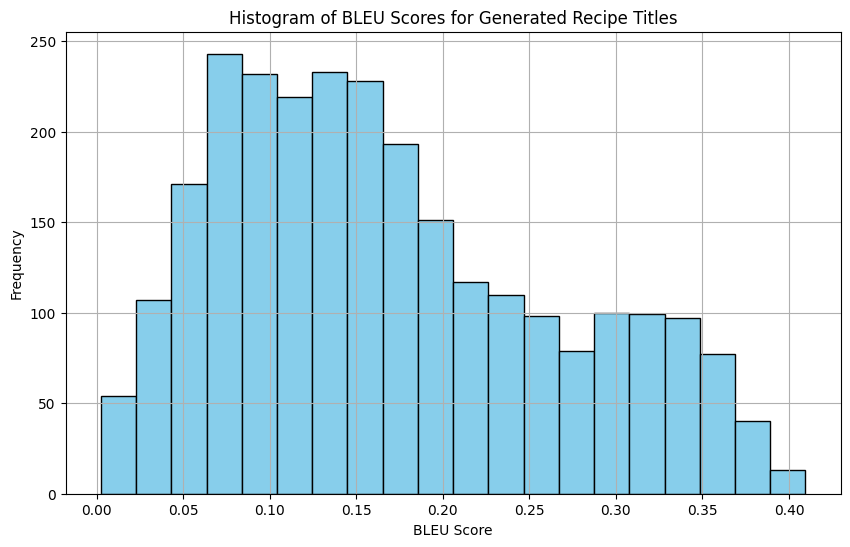

In [85]:
# Assuming `bleu_scores_random` is a list of your BLEU scores
bleu_scores = [score for score in bleu_scores_prompted]

# Create a histogram of the BLEU scores
plt.figure(figsize=(10, 6))
plt.hist(bleu_scores, bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram of BLEU Scores for Generated Recipe Titles')
plt.xlabel('BLEU Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()